# Майнор Интеллектуальный анализ данных / Введение в анализ данных

## Домашнее задание 3. Логистическая регрессия и случайный лес.

В этом задании вам предстоит:
- поработать с логистической регрессией (полная реализация не потребуется, однако можно заработать бонусные баллы)
- воспроизвести подход случайного леса через одно решающее дерево, поэкспериментировать со случайным лесом.

На все вопросы требуется отвечать развёрнуто, аппелируя к полученным значениям или графикам, ответы вписывать в отдельную ячейку, выбрав для неё тип "Markdown". От полноты и качества ответов будет во многом зависеть ваша итоговая оценка.

Задание выполняется самостоятельно, плагиат будет стандартно наказываться лишением всех баллов за задание.
- Максимальная оценка за задание: 10 баллов.
- Дата выдачи: 28.04.2018
- Срок сдачи: 23:59 18.05.2018

In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## Часть 0. Подготовка данных.

Для наших экспериентов возьмём обучающую выборку [отсюда](https://www.kaggle.com/iabhishekofficial/mobile-price-classification).

In [2]:
train = pd.read_csv('train.csv')

Решается задача многоклассовой классификации — определение ценовой категории телефона. Для простоты перейдём к задаче бинарной классификации — пусть исходные классы 0 и 1 соответствуют классу 0 новой целевой переменной, а остальные классу 1.

Замените целевую переменную, отделите её в отдельную переменную и удалите из исходной выборки.

In [3]:
target = train['price_range']

In [4]:
target = target.replace({1:0, 2:1, 3:1})

In [5]:
train.drop(['price_range'], axis = 1, inplace=True)

Разделите выборку на обучающую и тестовую части в соотношении 7 к 3. Для этого можно использовать `train_test_split` из scikit-learn. Не забудьте зафиксировать сид для разбиения.

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.3, random_state=42)

In [7]:
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

## Часть 1. Логистическая регрессия.

[4 балла]

В этой части вы будете обучать самый простой бинарный классификатор — логистическую регрессию. Будем использовать готовую реализацию `LogisticRegression` из scikit-learn.

Логистическая регрессия — линейный метод, то есть в нём предсказание алгоритма вычислаяется как скалярное произведение признаков и весов алгоритма: 

$$
b(x) = w_0 + \langle w, x \rangle = w_0 + \sum_{i=1}^{d} w_i x_i
$$

Для вычисления вероятности положительного класса применяется сигмоида. В результате предсказание вероятности принадлежности объекта к положительному классу можно записать как: 

$$
P(y = +1 | x) = \frac{1}{1 + \exp(- w_0 - \langle w, x \rangle )}
$$

Не забывайте, что для линейных методов матрицу объекты-признаки необходимо предварительно нормировать (то есть привести каждый признак к одному и тому же масштабу одним из способов). Для этого можно воспользоваться `StandardScaler` или сделать это вручную.

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

Обучите логистическую регрессию. Сделайте предсказания для тестовой части, посчитайте по ним ROC-AUC и Accuracy (порог 0.5). Хорошо ли удаётся предсказывать целевую переменную?

Не забывайте, что метод `predict_proba` вычисляет вероятности обоих классов выборки, а в бинарной классификации нас интересует в первую очередь вероятность принадлежности к положительному классу.

In [9]:
from sklearn.linear_model import LogisticRegression

In [81]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict_proba(X_test)[:,1]
y_pred_binary = lr.predict(X_test) #порог автоматически равен 0.5 
#в данном векторе содержатся бинарные прогнозы классификатора, чтобы посчитать Accuracy

In [11]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_pred)
print('ROC-AUC:', auc)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_binary) 
print('Accuracy:', accuracy)

ROC-AUC: 0.9997333066639997
Accuracy: 0.9833333333333333


Ответ: ROC-AUC и Accuracy близки к 1, поэтому можно сказать, что удается хорошо предсказать целевую переменную.

У обученной логистической регрессии есть два аттрибута: `coef_` и `intercept_`, которые соответствуют весам $w$ и $w_0$. Это и есть результат обучения логистической регрессии. Попробуйте с помощью них (с помощью всё той же обученной ранее логистической регрессии) посчитать "сырое" предсказание алгоритма $b(x)$. 


In [12]:
print(lr.coef_)
print(lr.intercept_)

[[ 2.22219188  0.02458364 -0.05143572 -0.07726888  0.0215056  -0.09943944
   0.04711604 -0.28593221 -0.32103246  0.11240541  0.10505236  1.13464323
   1.37171653  8.55988475 -0.02462275  0.14364385 -0.01898427  0.12171092
  -0.0636416  -0.17802943]]
[-0.0765016]


In [13]:
y_pred_raw = []
for i in range(len(X_test)):
    pr = (np.float(lr.intercept_ ) + np.sum( X_test[i]*lr.coef_))
    y_pred_raw.append(pr)

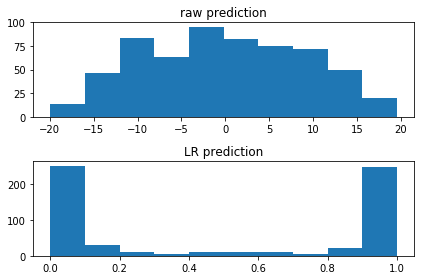

In [14]:
plt.figure(1)
plt.subplot(211)
plt.hist(y_pred_raw)
plt.title('raw prediction')
plt.subplot(212) 
plt.hist(y_pred)
plt.title('LR prediction')
plt.tight_layout()
plt.show()

Постройте гистограмму полученных значений и ответьте на вопросы:
- Какие значения принимает такое предсказание?
- Похожи ли эти значения на вероятность классов?

Ответ: По гистограмме полученных значений (raw prediction) видно, что "сырое" предсказание алгоритма принимает значения от -20 до примерно 20. Эти значения не похожи на вероятность классов. Вероятность классов, полученная с помощью логистической регрессии, представлена на второй гистограмме. Значения вероятности классов определяются в интервале между 0 и 1.

Реализуйте сигмоиду и постройте её график. Что вы можете сказать об этой функции?

Ответ: Функция сигмоиды определена от 0 до 1, что удобно использовать для определения вероятностей класса. Если передать произвольное вещественное число, можно получить соответствующее число в интервале между 0 и 1.  

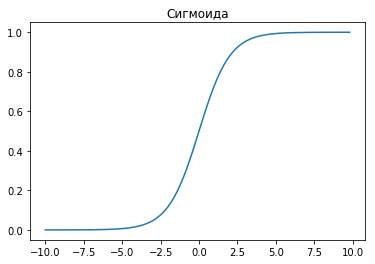

In [17]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))
x = np.arange(-10, 10, 0.2)
plt.plot(x, sigmoid(x))
plt.title('Сигмоида')
plt.show()

Примените реализованную сигмоиду к $b(x)$. Вы должны получить вероятности принадлежности к положительному классу. Проверьте, что ваши значения совпали с теми, которые получены с помощью `predict_proba`.

In [18]:
y_pred_sigm =list(map(sigmoid, y_pred_raw))

In [19]:
array = np.around(np.array(y_pred_sigm),5) == np.around(np.array(y_pred),5)
print('Количество False:', np.size(array) - np.count_nonzero(array))

Количество False: 0


False не встречается. Это доказывает, что значения совпали.

Таким образом, обучение логистической регрессии — настройка параметров $w$ и $w_0$, а применение — подсчёт вероятностей принадлежности положительному классу как применение сигмоды к скалярному произведению признаков и параметров.

Постройте для обученной логистической регрессии ROC-кривую `roc_curve` и PR-кривую `precision_recall_curve`.

In [22]:
from sklearn.metrics import roc_curve, precision_recall_curve

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

<function matplotlib.pyplot.show>

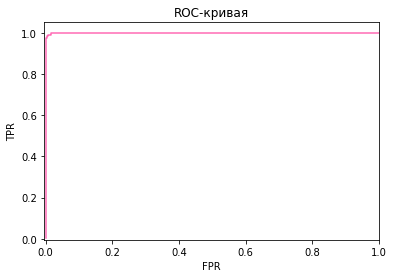

In [24]:
plt.plot(fpr, tpr, c='hotpink')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривая')
plt.ylim([-0.005, 1.05])
plt.xlim([-0.005, 1.0])
plt.show

In [25]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

<function matplotlib.pyplot.show>

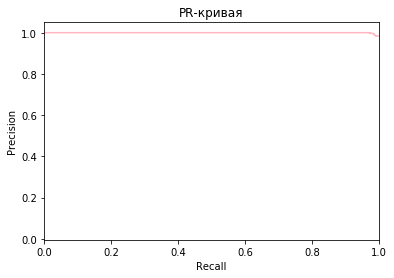

In [26]:
plt.plot(recall, precision, c='lightpink')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR-кривая')
plt.ylim([-0.005, 1.05])
plt.xlim([0.0, 1.0])
plt.show

## Часть 2. Случайные леса.

[6 баллов]

Случайный лес — алгоритм машинного обучения, представляющий собой бэггинг над решающими деревьями (усреднение ответов множества слабых алгоритмов) с 2 основными идеями:
- Использование подмножества признаков при построении каждого сплита дерева.
- Бутстрап обучающей выборки для построения каждого дерева (с повторениями).

В этом задании мы попробуем оценить пользу каждой из идей. Будем использовать ту же выборку с тем же разбиением на 2 части. Для начала обучите решающее дерево `DecisionTreeClassifier` из scikit-learn и посчитайте ROC-AUC и Accuracy (порог 0.5). Не забудьте зафикиксировать сид для построения дерева (несмотря на то, что в классической реализации никакой случайности нет, при большой глубине дерева может возникать неоднозначность в выборке признака в сплите). Используйте этот сид для всех заданий ниже.

In [27]:
from sklearn.tree import DecisionTreeClassifier

In [28]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
y_pred = tree.predict_proba(X_test)[:,1]
y_pred_binary = tree.predict(X_test)

In [29]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_pred)
print('ROC-AUC:', auc)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_binary)
print('Accuracy:', accuracy)

ROC-AUC: 0.934910157682435
Accuracy: 0.935


### 2.1 Бэггинг классификаторов

Реализуйте бэггинг над решающими деревьями (усреднение предсказанных вероятностей всего ансамбля). 
В качестве основы используйте всё тот же `DecisionTreeClassifier`. Количество базовых алгоритмов предлагается брать равным 100. 

Посчитайте качество с помощью тех же метрик. Ответьте на следующие вопросы:
- Что интересного вы видите?
- С чем это связано?

In [30]:
n = 100
y_pred1 = []
for i in range(n):
    tree = DecisionTreeClassifier(random_state=i)
    tree.fit(X_train, y_train)
    y_pred1.append(tree.predict_proba(X_test)[:,1])

In [31]:
y_pred_av = np.sum(y_pred1, axis = 0)/n

y_pred_av_binary = (y_pred_av > 0.5).astype(int)

In [32]:
auc = roc_auc_score(y_test, y_pred_av)
print('ROC-AUC:', auc)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_av_binary) 
print('Accuracy:', accuracy)

ROC-AUC: 0.9544121078774543
Accuracy: 0.945


Ответ: Качество при использовании бэггинга выросло, что видно по увеличению значения ROC-AUC. При усреднении деревьев можно добиться лучшей обобщающей способности.

### 2.2 Сэмплирование обучающей выборки

Добавим к нашему бэггингу бутстрап выборки (генерация случайной выборки того же размера с возвращением). Для этого может пригодиться `numpy.random.randint`.

Посчитайте качество. Что вы видите?

In [65]:
np.random.seed(123) 
n = 100
y_pred1 = []
for i in range(n):
    seq = numpy.random.randint(len(y_train), size = len(y_train))
    X_train_new = X_train[seq]
    y_train_new = y_train[seq]
    tree = DecisionTreeClassifier(random_state=i)
    tree.fit(X_train_new, y_train_new)
    y_pred1.append(tree.predict_proba(X_test)[:,1])

In [66]:
y_pred_av = np.sum(y_pred1, axis = 0)/n

y_pred_av_binary = (y_pred_av >= 0.5).astype(int)

In [67]:
auc = roc_auc_score(y_test, y_pred_av)
print('ROC-AUC:', auc)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_av_binary)
print('Accuracy:', accuracy)

ROC-AUC: 0.9930104121523263
Accuracy: 0.96


Ответ: Качество в этом случае по сравнению с качеством при использовании бэггинга значительно улучшилось.

### 2.3 Выбор случайного подмножества признаков

Временно забудем о бутстрапе выборки и добавим выбор случайного подмножества признаков при построении каждого сплита. В `DecisionTreeClassifier` за это отвечает параметр `max_features`. По умолчанию он имеет значение `None`, что обозначает использование всех возможных признаков. Для задачи классификации рекоменуется использовать квадратный корень от количества признаков. Попробуйте выставить такое значение. На этот раз надо отключить фиксированный сид в построении дерева, так как иначе каждый раз мы будем выбирать одинаковые подмножества признаков. 

Посчитайте качество. Что вы видите?

In [37]:
n = 100
y_pred1 = []
for i in range(n):
    tree = DecisionTreeClassifier(random_state=i, max_features = int(X_train.shape[1]**0.5))
    tree.fit(X_train, y_train)
    y_pred1.append(tree.predict_proba(X_test)[:,1])

In [38]:
y_pred_av = np.sum(y_pred1, axis = 0)/n

y_pred_av_binary = (y_pred_av >= 0.5).astype(int)

In [40]:
auc = roc_auc_score(y_test, y_pred_av)
print('ROC-AUC:', auc)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_av_binary)
print('Accuracy:', accuracy)

ROC-AUC: 0.99342156437866
Accuracy: 0.955


Ответ: Сравнивая с предыдущим подходом, при выборе случайного подмножества качество почти не изменилось.

### 2.4 = 2.2 + 2.3

Объединим два подхода (бутстрап + выбор подмножества признаков). Получим случайный лес.

Посчитайте качество. Что вы видите?

In [41]:
n = 100
y_pred1 = []
for i in range(n):
    seq = numpy.random.randint(len(y_train), size = len(y_train))
    X_train_new = X_train[seq]
    y_train_new = y_train[seq]
    tree = DecisionTreeClassifier(random_state=i,  max_features = int(X_train_new.shape[1]**0.5))
    
    tree.fit(X_train_new, y_train_new)
    y_pred1.append(tree.predict_proba(X_test)[:,1])

In [42]:
y_pred_av = np.sum(y_pred1, axis = 0)/n

y_pred_av_binary = (y_pred_av >= 0.5).astype(int)

In [43]:
auc = roc_auc_score(y_test, y_pred_av)
print('ROC-AUC:', auc)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_av_binary) 
print('Accuracy:', accuracy)

ROC-AUC: 0.9932604371548267
Accuracy: 0.9483333333333334


Ответ: При использовании двух методов качество также не изменилось, accuracy даже ухудшилось. В этом случае этот подход не самый эффективный.

То, что мы сделали уже реализовано в `RandomForestClassifier`. Попробуйте воспользоваться им. Количество используемых деревьев передаётся в параметре `n_estimators`.

Посчитайте качество. Что вы видите?

In [68]:
from sklearn.ensemble import RandomForestClassifier

In [69]:
rfc = RandomForestClassifier(random_state = 42, n_estimators = 1000)
rfc.fit(X_train, y_train)
y_pred = rfc.predict_proba(X_test)[:,1]
y_pred_binary = rfc.predict(X_test)

In [70]:
auc = roc_auc_score(y_test, y_pred)
print('ROC-AUC:', auc)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_binary) 
print('Accuracy:', accuracy)

ROC-AUC: 0.9938104921603271
Accuracy: 0.9516666666666667


In [71]:
rfc = RandomForestClassifier(random_state = 42, n_estimators = 100)
rfc.fit(X_train, y_train)
y_pred = rfc.predict_proba(X_test)[:,1]
y_pred_binary = rfc.predict(X_test)

In [72]:
auc = roc_auc_score(y_test, y_pred)
print('ROC-AUC:', auc)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_binary) 
print('Accuracy:', accuracy)

ROC-AUC: 0.9921881076996588
Accuracy: 0.9516666666666667


In [73]:
rfc = RandomForestClassifier(random_state = 42, n_estimators = 10)
rfc.fit(X_train, y_train)
y_pred = rfc.predict_proba(X_test)[:,1]
y_pred_binary = rfc.predict(X_test)

In [74]:
auc = roc_auc_score(y_test, y_pred)
print('ROC-AUC:', auc)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_binary) 
print('Accuracy:', accuracy)

ROC-AUC: 0.9845817915124846
Accuracy: 0.9416666666666667


Ответ: Качество зависит от настраиваемого гиперпараметра n_estimators. При использовании 1000 и 100 деревьев качество существенно лучше, чем при использовании 10. Однако, при использование 100 и 1000 деревьев качество остается примерно одинаковым.

### 2.5 Влияние количества используемых деревьев в случайном лесе

Один из параметров случайного леса — количество деревьев, используемых в бэггинге. Оценим, как влияет этот параметр на финальное качество. Для этого обучите случайные леса с разным количество деревьев (например, перебирайте от 10 до 1000 с шагом в 10), оцените качество с помощью ROC-AUC. Постройте график зависимости ROC-AUC от количества используемых деревьев. Что вы видите?

In [60]:
rocaucs = []
for i in np.arange(10,1000,10):
    rfc = RandomForestClassifier(random_state = 42, n_estimators = i)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_pred)
    rocaucs.append(auc)

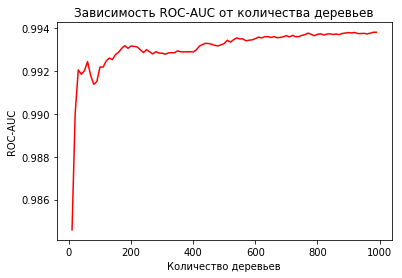

In [79]:
plt.plot(np.arange(10,1000,10), rocaucs, color='r')
plt.xlabel('Количество деревьев')
plt.ylabel('ROC-AUC')
plt.title('Зависимость ROC-AUC от количества деревьев')
plt.show()

Ответ: В целом, при увеличении количества деревьев качество стремится к 1. При начальном увеличении выборки (от 0 до 50 деревьев) качество резко увеличивается. Далее при использовании более 600 деревьев изменения не столь существенны.

### 2.6 Важность признаков

Случайный лес позволяет оценить важность признаков. У обученного случайного леса есть аттрибут `feature_importances_`, где хранится важность для каждого признака. Постройте `barplot` с важностью признаков (удобно использовать библиотеку `seaborn`, где можно для каждого столбца передать название признака `train.columns`).

In [62]:
import seaborn as sns

In [63]:
df_importance = pd.DataFrame({
    'feature':train.columns,
    'importance': rfc.feature_importances_
})

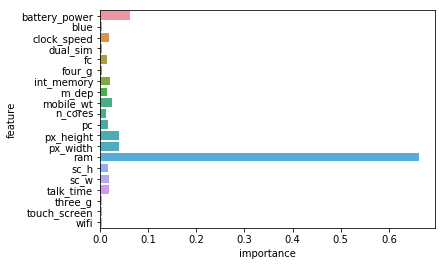

In [64]:
sns.barplot(y='feature', x = 'importance', data = df_importance)

Наиболее важным признаком для определения ценовой категории телефона является память (raw), затем идет мощность батареи (battery_power). Следующие одинаково важные признаки - это разрешение экрана (px_height, px_width).

## Выводы

Напишите, что интересного вы узнали в этой работе, в каких экспериментах какие результаты получились.


Использовались такие методы, как
- Разделение выборки на тестовую и обучающую
- Нормирование признаков
- Обучение с помощью логистической регрессии
- Предсказание принадлежности к классу при использовании сигмоиды
- Подсчет качества
- Различные методы над решающими деревьями (бэггинг, бутстрап и тд)
- Оценка важности признаков по случайному лесу

Результаты: 
- Удалось получить вероятности принадлежности к классам из значений логистической регрессии
- При использовании простого обучения решающего дерева и бэггинга классификаторов качество сравнительно ниже, чем при использовании других методов. Остальные подходы трудно сравнить между собой, потому что качество одинаково высокое
- Решающее дерево уступает по качеству случайным лесам
- Качество случайного леса сильно зависит от количества используемых значений
- Удалось определить наиболее важные признаки для ценовой категории товара